In the following section of the code, we have imported all the libraries that are needed for both datasets

In [34]:
# Importing the libraries 

import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pickle
import csv
from kneed import KneeLocator
import os
%matplotlib inline
from numpy import asarray
import seaborn as sns
import nltk
import re
import warnings
import pandas as pd
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy as hier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score,calinski_harabasz_score
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/poojamahajan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In the following section of the code, we have defined the functions that are common for both datasets

In [4]:
# k-Means Algorithm: Expectation–Maximization

def find_clusters(X, n_clusters, metric1, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    print(type(metric1))
    print(metric1)
    
    while True:
        # 2a. Assign labels based on closest center 
        #metric can be  'cosine', 'euclidean', 'manhattan'
        labels = pairwise_distances_argmin(X, centers, 1, metric1)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [5]:
# Evaluation method: Silhouette Score
 
def silhoutte_evaluation(dataset,start,end,metric):
    
    tmp_sil=[]
    for n in range(start,end):
        centers, labels=find_clusters(dataset, n, metric)
        silhouette_scores = silhouette_score(dataset, labels)
        tmp_sil.append(silhouette_scores)
        
    plt.figure(figsize=(8, 3))
    plt.plot(range(start, end), tmp_sil, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)  
#     df3['scores'] = silhouette_scores
#     df4 = df3[df3.scores == df3.scores.max()]
#     print('Score:', df4['scores'].tolist())
#     print('Optimal number of clusters based on score:', df4['centers'].tolist())
    return(plt.show())

In [6]:
#Evaluation method: Davies Bouldin Score

def db_evaluation(dataset,start,end,metric):
    
    db_score=[]
    for n in range(start,end):
        centers, labels=find_clusters(dataset, n, metric)
        db = davies_bouldin_score(dataset,labels)
        db_score.append(db)
    
    plt.figure(figsize=(8, 3))
    plt.plot(range(start, end),db_score, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Davies Bouldin score", fontsize=14)
    print(db_score)
    return(plt.show())  

In [7]:
# KElbow Visualiser for validating evaluation results

def model_visualiser(model,start,end,m,dataset):
    
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(start,end),metric=m,timings= True, locate_elbow=True)
    visualizer.fit(dataset)# Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

    df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
    df3['scores'] = visualizer.k_scores_
    df4 = df3[df3.scores == df3.scores.max()]
    print('Score:', df4['scores'].tolist())
    print('Optimal number of clusters based on score:', df4['centers'].tolist())

In [8]:
#  Agglomerative hierarchical clustering

def hierarchical_model(dist_matrix):
    
    proximity_matrix = pdist(dist_matrix)
    
    single = linkage(proximity_matrix, method='single')
    complete = linkage(proximity_matrix, method='complete')
    average = linkage(proximity_matrix, method='average')

    # For identifying which linkage is best
    single_cophenet = hier.cophenet(single, proximity_matrix)
    print("Single:", single_cophenet[0])
    complete_cophenet = hier.cophenet(complete, proximity_matrix)
    print("Complete:", complete_cophenet[0])
    average_cophenet = hier.cophenet(average, proximity_matrix)
    print("Average:", average_cophenet[0])
    
    return(single_cophenet[0],complete_cophenet[0],average_cophenet[0])

In [9]:
# Parameter tuning for eps

def eps_parameter_tuning(dataset,n):
    
    nearest_neighbors = NearestNeighbors(n_neighbors=n)
    neighbors = nearest_neighbors.fit(dataset)
    distances, indices = neighbors.kneighbors(dataset)
    distances = np.sort(distances[:,10], axis=0)

    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    fig = plt.figure(figsize=(5, 5))
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")

    eps=distances[knee.knee]
    return(eps)

In [10]:
# Defining DB scan algorithm and evaluating with Silhouette Score
 
def db_scan_silhouette(eps,dataset,metric):
    
    def get_dbscan_score(data, center):

    #instantiate kmeans
        dbscan = DBSCAN(eps, min_samples=center)

        # Then fit the model to your data using the fit method
        model = dbscan.fit(dataset)

        # Calculate Silhoutte Score

        score = silhouette_score(dataset, model.labels_, metric=metric)

        return score

    scores = []
    centers = list(range(2,30))

    for center in centers:
        scores.append(get_dbscan_score(dataset, center))

    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('min_samples');
    plt.ylabel('Silhouette Score');
    plt.title('Silhouette Score vs. min_samples');

    df3 = pd.DataFrame(centers,columns=['min_samples'])
    df3['scores'] = scores
    df4 = df3[df3.scores == df3.scores.max()]
    print('Score:', df4['scores'].tolist())
    print('Optimal number of min_samples based on silhouette score:', df4['min_samples'].tolist())
    

In [11]:
# Defining DB scan algorithm and evaluating with Silhouette Score
 
def db_scan_calinski_harabasz(eps,dataset):
    
    def get_dbscan_score(data, center):

    #instantiate kmeans
        dbscan = DBSCAN(eps, min_samples=center)

        # Then fit the model to your data using the fit method
        model = dbscan.fit(dataset)

        # Calculate calinski_harabasz Score

        score = calinski_harabasz_score(dataset, model.labels_)

        return score

    scores = []
    centers = list(range(2,30))

    for center in centers:
        scores.append(get_dbscan_score(dataset, center))

    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('min_samples');
    plt.ylabel('Calinski Harabasz Score');
    plt.title('Calinski Harabasz Score vs. min_samples');

    df3 = pd.DataFrame(centers,columns=['min_samples'])
    df3['scores'] = scores
    df4 = df3[df3.scores == df3.scores.max()]
    print('Optimal number of min_samples based on Calinski Harabasz score:', df4['min_samples'].tolist())

# 1. Data set up

## 1.1 Load Data

### Dataset  - Multi-Domain Sentiment Dataset

In [15]:
# Read the dataset, split the text and labels and store it in a dataframe

df=pd.DataFrame()
output=[]
with open("amazon_book.review",'r',encoding="utf8") as f:
    for line in f.readlines():
        txt=""
        kv=line.split()
        D={}
        for key_value in kv:
            key, value = key_value.split(':')
            if key !='#label#':
                txt+=' '+(key+' ')*int(value)
                D['text']=txt
            else:
                D['label']=value
        output.append(D)
df = pd.DataFrame(output)

In [16]:
# Print the dataframe

df 

,text,label
0,helpful voices_of the_levels it only_knew...,5.0
1,i i i keeper somewhere to_someone job_now...,1.0
2,a a a advice into_my and_does come_close ...,5.0
3,it_would count_system continually found s...,2.0
4,yet.unless and_sporatic it it it it it see...,1.0
...,...,...
5496,one_more my my been been annoyed descript...,1.0
5497,strikes_rule nicely is_facing (didn't gui...,4.0
5498,science_fiction which ursula mostly_relega...,2.0
5499,i only suffered_at allowing one culminat...,5.0


## 1.2 Data Visualization

<AxesSubplot:xlabel='label', ylabel='count'>

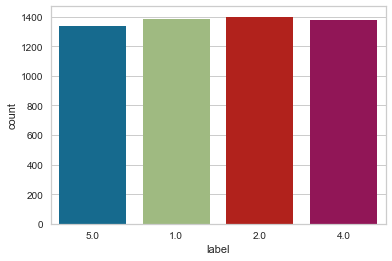

In [17]:
# Visualize the clusters of labels in the dataset
sns.countplot(df.label)

In [18]:
# Tokenization and stemming

stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
        #if token not in stopword_all:
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [19]:
# TF-IDF vectorization

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [20]:
# Put the text part of the dataframe in an array

txt=df['text'].values 
%time tfidf_matrix = tfidf_vectorizer.fit_transform(txt)

CPU times: user 37.3 s, sys: 493 ms, total: 37.8 s
Wall time: 37.9 s


In [25]:
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_matrix.shape)

(5501, 30)


In [27]:
# Create a dataframe with tf-idf vectorized features  

features = tfidf_vectorizer.transform(df.text).toarray()
df_Tf_idf = pd.DataFrame(features, columns=tfidf_vectorizer.get_feature_names(), index=df.index)

In [28]:
df_Tf_idf.head()

,'s,and_th,author,book book,book book book,book_i,good,great,if_you,in_th,...,read,the_book,this_book,this_book this_book,this_i,time,to_b,to_th,use,veri
0,0.624628,0.0000,0.000000,0.000000,0.000000,0.000000,0.00000,0.491018,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.152694,0.00000,0.000000
1,0.275125,0.4265,0.000000,0.263546,0.174215,0.181842,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.353579,0.130400,0.0,0.0,0.205509,0.424914,0.201768,0.00000,0.185442
2,0.440281,0.0000,0.000000,0.421751,0.000000,0.000000,0.30964,0.000000,0.000000,0.000000,...,0.237269,0.000000,0.208678,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.281353,0.0000,0.000000,0.269511,0.178159,0.371917,0.00000,0.000000,0.221401,0.174092,...,0.000000,0.361582,0.133352,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
4,0.000000,0.0000,0.118986,0.076172,0.000000,0.000000,0.00000,0.000000,0.000000,0.098407,...,0.000000,0.000000,0.000000,0.0,0.0,0.118795,0.245623,0.000000,0.12106,0.000000




---


# 2. K-means Clustering

### Train K-means clustering

In [29]:
# K-means data clusters for k = 4

num_clusters = 4
km = KMeans(n_clusters=num_clusters)
%time pos = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
df['cluster']=clusters
df['cluster'].value_counts() #number of cases per cluster (clusters from 0 to 4)
print(df.head())
#set up cluster names using a dict
cluster_names = {0: 'Cluster1', 1: 'Cluster2', 2: 'Cluster3', 3:'Cluster4'}
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3:'#FF00FF'}

CPU times: user 1.59 s, sys: 196 ms, total: 1.78 s
Wall time: 360 ms
                                                text label  cluster
0   helpful  voices_of  the_levels  it  only_knew...   5.0        0
1   i i i  keeper  somewhere  to_someone  job_now...   1.0        1
2   a a a  advice  into_my  and_does  come_close ...   5.0        3
3   it_would  count_system  continually  found  s...   2.0        3
4   yet.unless  and_sporatic  it it it it it  see...   1.0        2


In [30]:
# Visualize the data clusters to get an approximate value of k (number of clusters) 

cost =[]
label=[]
clusters=[]

for i in range(1,11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    km_fit=KM.fit(tfidf_matrix)
    y_kmeans=KM.predict(tfidf_matrix)
    label.append(y_kmeans)
    clusters.append(KM)
    cost.append(KM.inertia_)
print(cost)

[3983.3004679662185, 3572.17216151784, 3212.0661189319994, 2994.0210709141206, 2841.980959223824, 2734.835667260968, 2670.3246146932775, 2621.4346829875067, 2554.3530759869595, 2526.464223579143]


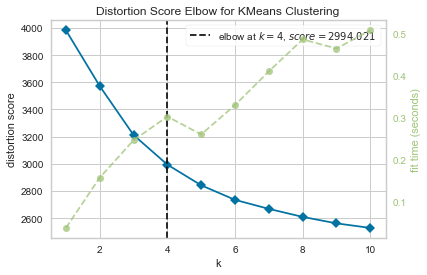

Score: [3983.3004679662063]
Optimal number of clusters based on score: [1]


In [31]:
# Visualising k-means model for k = (1,11)

model_visualiser(KM,1,11,"distortion",tfidf_matrix)

In [35]:
%%time 
#The following code takes 30 mins approx to execute

# Verify if k=4 is an optimal value through visulaization

#X=tfidf_matrix.toarray()
dist = 1 - cosine_similarity(tfidf_matrix)
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()



CPU times: user 11min 20s, sys: 36min 11s, total: 47min 32s
Wall time: 10min 2s


<class 'str'>
cosine


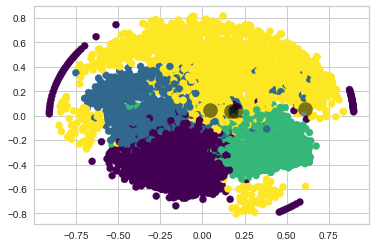

In [36]:
centers, labels = find_clusters(X, 4, "cosine")
plt.scatter(xs, ys, c=labels,
                s=50, cmap='viridis');

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# Evaluation

We will evaluate K-means EM model using the following combination of:<br>
distance metrics: {euclidean, cosine} and evalaution methods:{Silhouette score, Davies Bouldin score}<br>

1) euclidean-sihoutte<br>
2) cosine-silhouette<br>
3) euclidean-DB<br>
4) cosine-DB<br>

## First evaluation

### Kmeans- Evaluation Method-1 (Silhouette score)

In [37]:
dist = 1 - cosine_similarity(tfidf_matrix)
X=dist

<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
0.26913110857740913


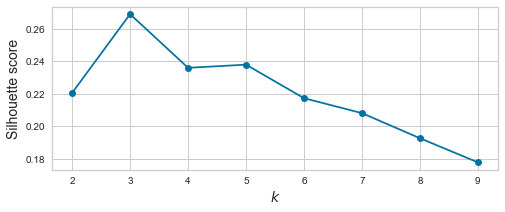

CPU times: user 2min 37s, sys: 1min 24s, total: 4min 2s
Wall time: 33.2 s


In [38]:
%%time
# 1) euclidean-sihoutte

from sklearn.metrics import silhouette_score
tmp_sil=[]
for n in range(2,10):
    centers, labels=find_clusters(X, n, "euclidean")
    silhouette_scores = silhouette_score(X, labels)
    tmp_sil.append(silhouette_scores)

max_score=tmp_sil[0]
for i in range(1,8):     
    if tmp_sil[i] > max_score:         
        max_score = tmp_sil[i] 
print(max_score) 
    
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), tmp_sil, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.show()

<class 'str'>
euclidean


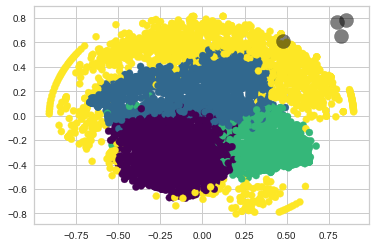

In [40]:
centers, labels = find_clusters(X, 4, "euclidean")
plt.scatter(xs, ys, c=labels,
                s=50, cmap='viridis');

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
0.20372827313871458


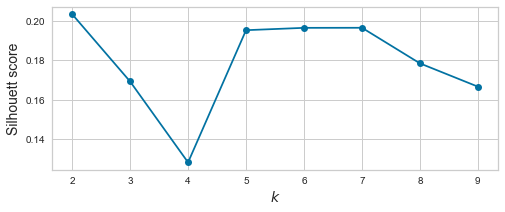

CPU times: user 2min 46s, sys: 2min 24s, total: 5min 11s
Wall time: 44.2 s


In [41]:
%%time
#2) cosine-silhouette 


tmp_sil=[]
for n in range(2,10):
    centers, labels=find_clusters(X, n, "cosine")
    silhouette_scores = silhouette_score(X, labels)
    tmp_sil.append(silhouette_scores)

max_score=tmp_sil[0]
for i in range(1,8):     
    if tmp_sil[i] > max_score:         
        max_score = tmp_sil[i] 
print(max_score) 
    
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), tmp_sil, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouett score", fontsize=14)
plt.show()

## Second evaluation 

## Kmeans- Evaluation Method-2 (Davies Bouldin Score)

<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
<class 'str'>
euclidean
0.1692513092056536


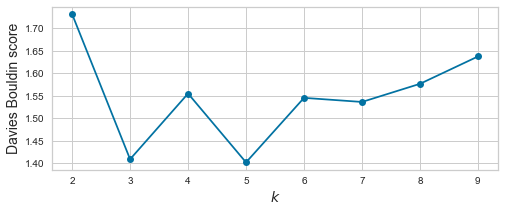

CPU times: user 45.6 s, sys: 1min 7s, total: 1min 53s
Wall time: 15.5 s


In [42]:
%%time
# 3) euclidean-davies_bouldin_score

db_score=[]
for n in range(2,10):
    centers, labels=find_clusters(X, n, "euclidean")
    db = davies_bouldin_score(X,labels)
    db_score.append(db)

min_score=db_score[0]
for i in range(1,8):     
    if db_score[i] < min_score:         
        min_score = tmp_sil[i] 
print(min_score) 

    
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10),db_score, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Davies Bouldin score", fontsize=14)
plt.show()

<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
<class 'str'>
cosine
1.6417806449563328


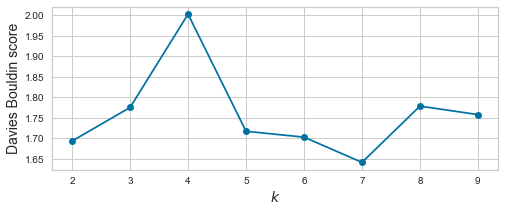

CPU times: user 51.1 s, sys: 2min 13s, total: 3min 4s
Wall time: 26.2 s


In [43]:
%%time
# 4) cosine-davies_bouldin_score

db_score=[]
for n in range(2,10):
    centers, labels=find_clusters(X, n, "cosine")
    db = davies_bouldin_score(X,labels)
    db_score.append(db)

min_score=db_score[0]
for i in range(1,8):     
    if db_score[i] < min_score:         
        min_score = db_score[i] 
print(min_score) 

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10),db_score, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Davies Bouldin score", fontsize=14)
plt.show()



---


# 3. Hierachical Clustering

### Train Hierarchical clustering 

In [56]:
# Training hierarchical model on cosine distance matrix
proximity_matrix = pdist(dist)


single = linkage(proximity_matrix, method='single')
complete = linkage(proximity_matrix, method='complete')
average = linkage(proximity_matrix, method='average')

single_cophenet = hier.cophenet(single, proximity_matrix)
print("Single:", single_cophenet[0])
complete_cophenet = hier.cophenet(complete, proximity_matrix)
print("Complete:", complete_cophenet[0])
average_cophenet = hier.cophenet(average, proximity_matrix)
print("Average:", average_cophenet[0])


Single: -0.036310332393972106
Complete: 0.6002113194322574
Average: 0.6735684475400006


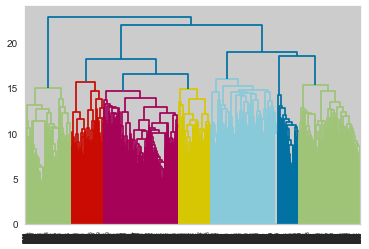

In [55]:
# Visualising based on the best linkage method
dendro = dendrogram(average)

# Evaluation

We will evaluate Hierarchical model using the following combination of:<br> 
linkage: {single, average, complete} <br>
distance metrics: {euclidean, cosine, manhattan}<br>
evalaution methods:{Silhouette score, Calinski Harabasz Score}<br>


## First evaluation

### Hierarchical- Evaluation Method-1 (Silhouette Score)


This evaluation methods has the following combinations:<br>
1) single-euclidean-silhouette<br>
2) average-euclidean-silhouette<br>
3) complete-euclidean-silhouette<br><br>

4) single-cosine-silhouette<br>
5) average-cosine-silhouette<br>
6) complete-cosine-silhouette<br><br>

7) single-manhattan-silhouette<br>
8) average-manhattan-silhouette<br>
9) complete-manhattan-silhouette <br>

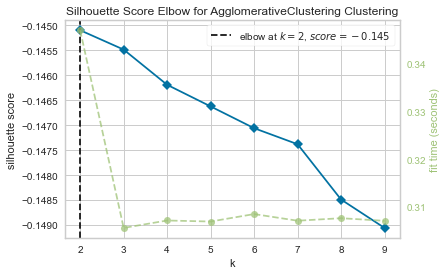

Score: [-0.1450999038410213]
Optimal number of clusters based on score: [2]


In [57]:
# 1) single-euclidean-silhouette
hc = AgglomerativeClustering(affinity='euclidean', linkage ='single')
model_visualiser(hc,2,10,"silhouette", tfidf_matrix.toarray())

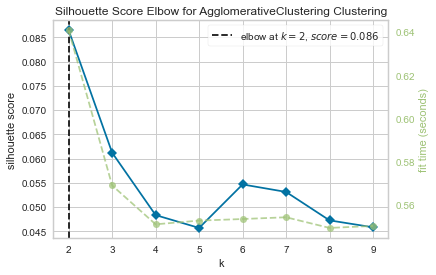

Score: [0.08646144431072476]
Optimal number of clusters based on score: [2]


In [58]:
# 2) average-euclidean-silhouette
hc = AgglomerativeClustering(affinity='euclidean', linkage = 'average')
model_visualiser(hc,2,10,"silhouette", tfidf_matrix.toarray())

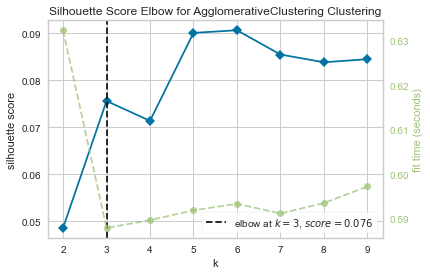

Score: [0.09065998201683995]
Optimal number of clusters based on score: [6]


In [59]:
# 3) complete-euclidean-silhouette
hc = AgglomerativeClustering(affinity='euclidean', linkage = 'complete')
model_visualiser(hc,2,10,"silhouette", tfidf_matrix.toarray())

In [60]:
dist = 1 - cosine_similarity(tfidf_matrix)
X=dist

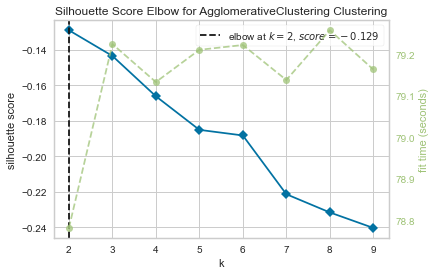

Score: [-0.12903711314360278]
Optimal number of clusters based on score: [2]
CPU times: user 12min 26s, sys: 21.4 s, total: 12min 47s
Wall time: 10min 51s


In [61]:
%%time 
#The following code takes 30 mins approx to execute

# 4) single-cosine -silhouette
hc = AgglomerativeClustering(affinity='cosine', linkage ='single')
model_visualiser(hc,2,10,"silhouette", X)

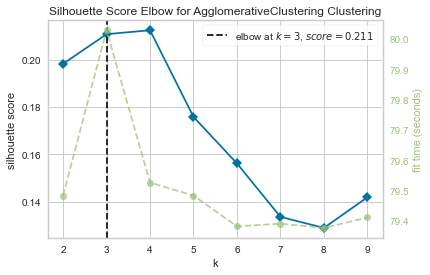

Score: [0.21237712810057036]
Optimal number of clusters based on score: [4]
CPU times: user 12min 31s, sys: 22.9 s, total: 12min 54s
Wall time: 10min 54s


In [62]:
%%time 
#The following code takes 30 mins approx to execute

# 5) average-cosine -silhouette
hc = AgglomerativeClustering(affinity='cosine', linkage = 'average')
model_visualiser(hc,2,10,"silhouette", X)

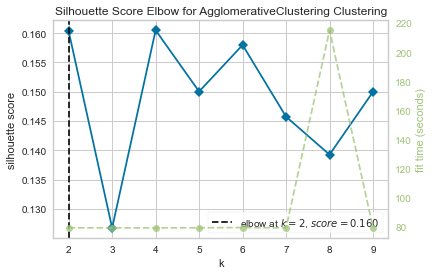

Score: [0.16049962655895064]
Optimal number of clusters based on score: [4]
CPU times: user 12min 31s, sys: 22.8 s, total: 12min 54s
Wall time: 13min 9s


In [63]:
%%time 
#The following code takes 30 mins approx to execute

# 6) complete-cosine -silhouette
hc = AgglomerativeClustering(affinity='cosine', linkage = 'complete')
model_visualiser(hc,2,10,"silhouette", X)

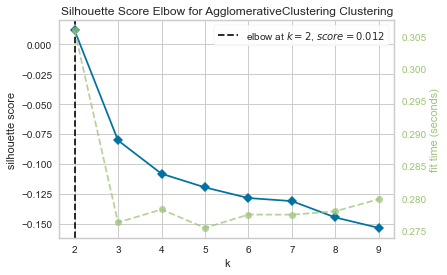

Score: [0.011687763248441075]
Optimal number of clusters based on score: [2]


In [64]:
# 7) single-manhattan -silhouette
hc = AgglomerativeClustering(affinity='manhattan', linkage ='single')
model_visualiser(hc,2,10,"silhouette", tfidf_matrix.toarray())

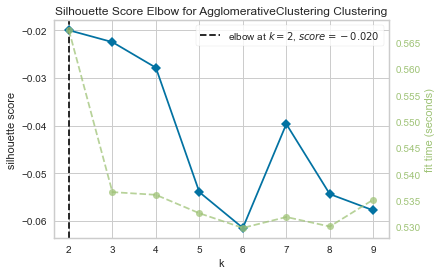

Score: [-0.019949447836663546]
Optimal number of clusters based on score: [2]


In [66]:
# 8) average- manhattan -silhouette
hc = AgglomerativeClustering(affinity='manhattan', linkage = 'average')
model_visualiser(hc,2,10,"silhouette", tfidf_matrix.toarray())

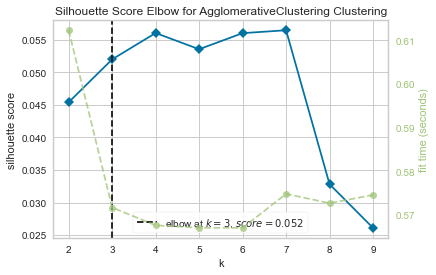

Score: [0.05643783320619685]
Optimal number of clusters based on score: [7]


In [67]:
# 9) complete- manhattan -silhouette
hc = AgglomerativeClustering(affinity='manhattan', linkage = 'complete')
model_visualiser(hc,2,10,"silhouette", tfidf_matrix.toarray())


## Second evalaution 

### Hierarchical- Evaluation Method-2 (calinski_harabasz Score) : Variance Ratio Criterion


This evaluation methods has the following combinations:<br>
1) single-euclidean-calinski_harabasz<br>
2) average-euclidean-calinski_harabasz<br>
3) complete-euclidean-calinski_harabasz<br><br>

4) single-cosine-calinski_harabasz<br>calinski_harabasz
5) average-cosine-calinski_harabasz<br>
6) complete-cosine-calinski_harabasz<br><br>

7) single-manhattan-calinski_harabasz<br>
8) average-manhattan-calinski_harabasz<br>
9) complete-manhattan-calinski_harabasz <br>

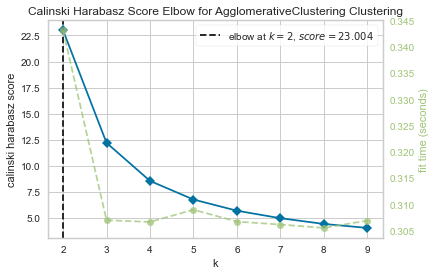

Score: [23.00371616450718]
Optimal number of clusters based on score: [2]


In [68]:
# 1) single-euclidean- calinski_harabasz
hc = AgglomerativeClustering(affinity='euclidean', linkage ='single')
model_visualiser(hc,2,10,'calinski_harabasz', tfidf_matrix.toarray())

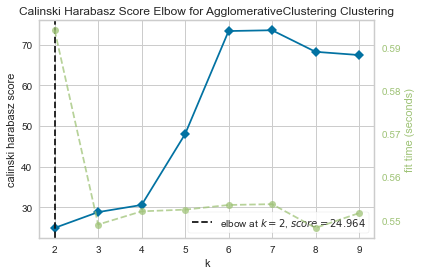

Score: [73.57563327940933]
Optimal number of clusters based on score: [7]


In [69]:
# 2) average-euclidean- calinski_harabasz
hc = AgglomerativeClustering(affinity='euclidean', linkage = 'average')
model_visualiser(hc,2,10,'calinski_harabasz', tfidf_matrix.toarray())

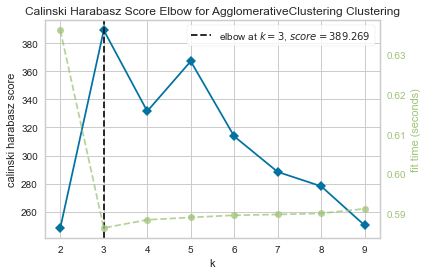

Score: [389.2692644129604]
Optimal number of clusters based on score: [3]


In [70]:
# 3) complete-euclidean- calinski_harabasz
hc = AgglomerativeClustering(affinity='euclidean', linkage = 'complete')
model_visualiser(hc,2,10,'calinski_harabasz', tfidf_matrix.toarray())

In [71]:
dist = 1 - cosine_similarity(tfidf_matrix)
X=dist

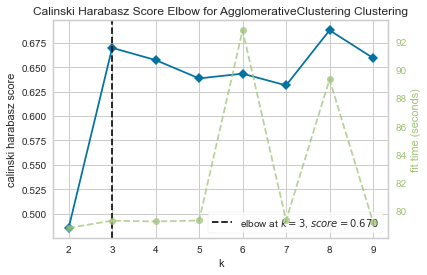

Score: [0.6877700446850656]
Optimal number of clusters based on score: [8]
CPU times: user 10min 33s, sys: 2.43 s, total: 10min 35s
Wall time: 10min 59s


In [72]:
%%time 
#The following code takes 30 mins approx to execute

# 4) single-cosine - calinski_harabasz
hc = AgglomerativeClustering(affinity='cosine', linkage ='single')
model_visualiser(hc,2,10,'calinski_harabasz', X)

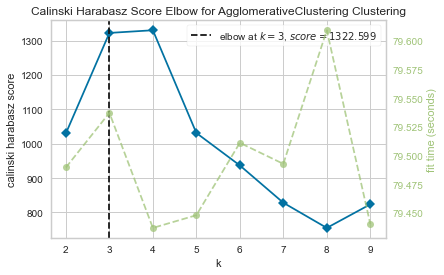

Score: [1330.3940357246643]
Optimal number of clusters based on score: [4]
CPU times: user 10min 35s, sys: 1.64 s, total: 10min 37s
Wall time: 10min 37s


In [73]:
%%time 
#The following code takes 30 mins approx to execute

# 5) average-cosine - calinski_harabasz
hc = AgglomerativeClustering(affinity='cosine', linkage = 'average')
model_visualiser(hc,2,10,'calinski_harabasz', X)

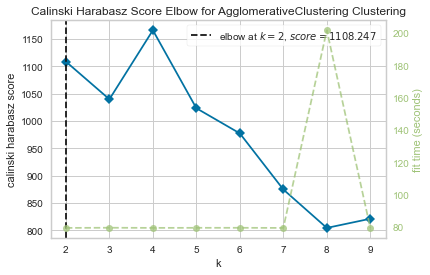

Score: [1165.4866516450559]
Optimal number of clusters based on score: [4]
CPU times: user 10min 34s, sys: 1.44 s, total: 10min 36s
Wall time: 12min 38s


In [74]:
%%time 
#The following code takes 30 mins approx to execute

# 6) complete-cosine - calinski_harabasz
hc = AgglomerativeClustering(affinity='cosine', linkage = 'complete')
model_visualiser(hc,2,10,'calinski_harabasz', X)

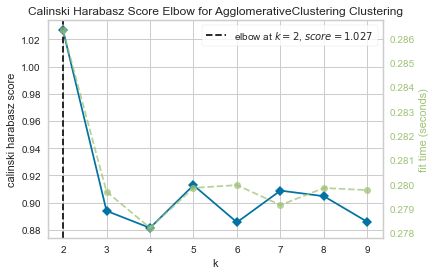

Score: [1.0267521854300907]
Optimal number of clusters based on score: [2]


In [75]:
# 7) single- manhattan - calinski_harabasz
hc = AgglomerativeClustering(affinity='manhattan', linkage ='single')
model_visualiser(hc,2,10,'calinski_harabasz', tfidf_matrix.toarray())

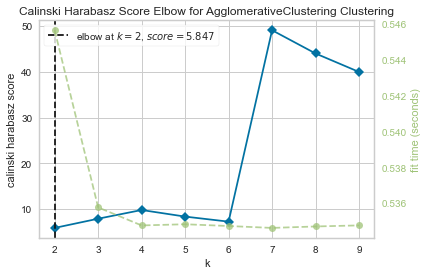

Score: [49.08875587843459]
Optimal number of clusters based on score: [7]


In [76]:
# 8) average- manhattan - calinski_harabasz
hc = AgglomerativeClustering(affinity='manhattan', linkage = 'average')
model_visualiser(hc,2,10,'calinski_harabasz', tfidf_matrix.toarray())

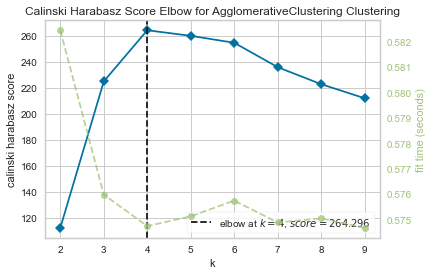

Score: [264.2964212248053]
Optimal number of clusters based on score: [4]


In [77]:
# 9) complete- manhattan - calinski_harabasz
hc = AgglomerativeClustering(affinity='manhattan', linkage = 'complete')
model_visualiser(hc,2,10,'calinski_harabasz', tfidf_matrix.toarray())




---


# 4. DBSCAN Clustering

### Train DBSCAN clustering 

<Figure size 360x360 with 0 Axes>

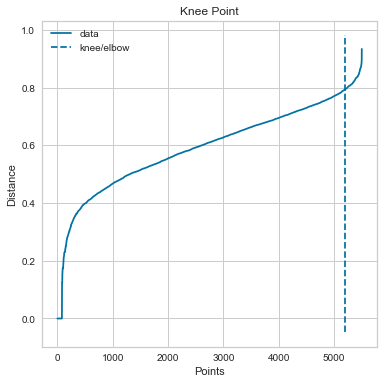

In [78]:
# Parameter tuning for eps

eps_bookreview = eps_parameter_tuning(tfidf_matrix,1000)

# Evaluation

We will evaluate DBSCAN model using the following combination of:<br> distance metrics: {euclidean, cosine, manhattan} and evalaution methods:{Silhouette score, Davies Bouldin score}<br>
1) euclidean-sihoutte<br>
2) cosine-silhouette<br>
3) manhattan-silhouette<br>

4) euclidean-DB<br>
5) cosine-DB<br>
6) manhattan-DB <br>


## First evaluation 

### DBSCAN- Evaluation Method-1 (Silhouette Score)

Score: [-0.1422134988741837]
Optimal number of min_samples based on silhouette score: [29]


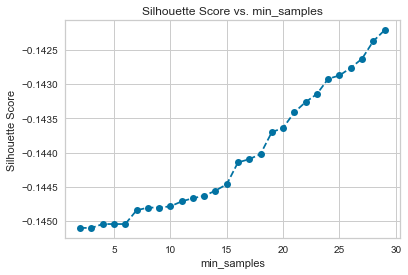

In [79]:
#silhouette-Euclidean

db_scan_silhouette(eps_bookreview,tfidf_matrix,"euclidean")

Score: [0.15256970675884107, 0.15256970675884107, 0.15256970675884107]
Optimal number of min_samples based on silhouette score: [4, 5, 6]


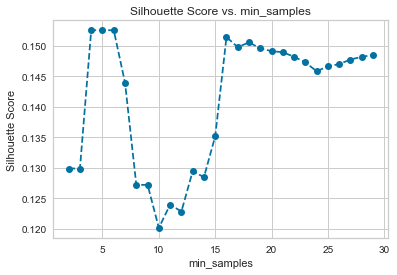

In [80]:
#silhouette-cosine

db_scan_silhouette(eps_bookreview,tfidf_matrix,"cosine")

Score: [-0.33059252695256663]
Optimal number of min_samples based on silhouette score: [29]


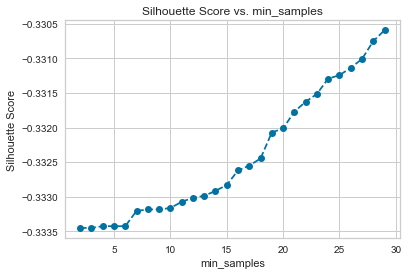

In [81]:
#silhouette-manhattan

db_scan_silhouette(eps_bookreview,tfidf_matrix,"manhattan")

<class 'str'>
manhattan
CPU times: user 3.29 s, sys: 194 ms, total: 3.49 s
Wall time: 3.54 s


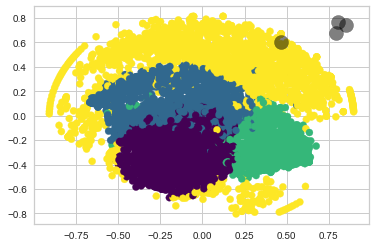

In [82]:
%%time
centers, labels = find_clusters(X, 4, "manhattan")
plt.scatter(xs, ys, c=labels,
                s=50, cmap='viridis');

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Second evaluation 

### DBSCAN - Evaluation Method-2 (calinski_harabasz)

Optimal number of min_samples based on Calinski Harabasz score: [21, 22, 23, 24, 25, 26, 27, 28, 29]


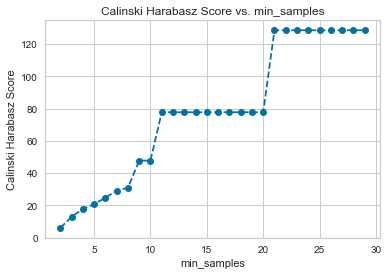

In [84]:
dist=1-cosine_similarity(tfidf_matrix)
db_scan_calinski_harabasz(eps_bookreview, dist)